# Régression logistique sur echonest

On entraîne ici une régression logistique multiclasse pour prédire les 16 différents genres de musiques présents dans le dataset à partir des features extraites par le module echonest.

On choisis ici ces features car elles ont l'avantage d'être peu nombreuses et surtout interprétables, ce qui est l'intérêt premier de l'exercice ici.

### I. Import des données

In [1]:
import pandas as pd
echonest = pd.read_csv('data/fma_metadata/echonest.csv')

/tmp/ipykernel_145024/1677181543.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,11,13,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249) have mixed types. Specify dtype option on import or set low_m

In [2]:
echonest = echonest.iloc[:,:9]

Ici le dataframe contenant les features echonest pour l'entraînement du classifieur

In [3]:
new_columns = echonest.iloc[1]
echonest.columns = new_columns
new_columns.iloc[0] = 'track_id' 
echonest = echonest.iloc[3:].reset_index(drop=True)

echonest

1,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.4166752327,0.6758939853,0.6344762684,0.0106280683,0.1776465712,0.1593100648,165.9220000000,0.5766609880
1,3,0.3744077685,0.5286430621,0.8174611317,0.0018511032,0.1058799438,0.4618181276,126.9570000000,0.2692402421
2,5,0.0435668989,0.7455658702,0.7014699916,0.0006967990,0.3731433124,0.1245953419,100.2600000000,0.6216612236
3,10,0.9516699648,0.6581786543,0.9245251615,0.9654270154,0.1154738842,0.0329852191,111.5620000000,0.9635898919
4,134,0.4522173071,0.5132380502,0.5604099311,0.0194426943,0.0965666940,0.5255193792,114.2900000000,0.8940722715
...,...,...,...,...,...,...,...,...,...
13124,124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.08255,141.332,0.890461
13125,124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845
13126,124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667
13127,124864,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274


In [4]:
tracks = pd.read_csv('data/fma_metadata/tracks.csv')
tracks.rename(columns={'Unnamed: 0':'track_id'},inplace=True)

/tmp/ipykernel_145024/37850579.py:1: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  tracks = pd.read_csv('data/fma_metadata/tracks.csv')


On importe ensuite le dataframe qui contient les labels à prédire

In [5]:
label = tracks[['track_id','track.7','set']]
label.rename(columns={'track.7':'genre_top'},inplace=True)
label = label[2:]

label

/tmp/ipykernel_145024/1089924658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label.rename(columns={'track.7':'genre_top'},inplace=True)


,track_id,genre_top,set
2,2,Hip-Hop,training
3,3,Hip-Hop,training
4,5,Hip-Hop,training
5,10,Pop,training
6,20,NaN,training
...,...,...,...
106571,155316,Rock,training
106572,155317,Rock,training
106573,155318,Rock,training
106574,155319,Rock,training


On obtient ensuite le dataset entier auquel on retire toutes les lignes avec un label manquant

In [6]:
full_set = pd.merge(echonest,label,how='inner',on='track_id')
full_set.dropna(inplace=True)
full_set

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,set
0,2,0.4166752327,0.6758939853,0.6344762684,0.0106280683,0.1776465712,0.1593100648,165.9220000000,0.5766609880,Hip-Hop,training
1,3,0.3744077685,0.5286430621,0.8174611317,0.0018511032,0.1058799438,0.4618181276,126.9570000000,0.2692402421,Hip-Hop,training
2,5,0.0435668989,0.7455658702,0.7014699916,0.0006967990,0.3731433124,0.1245953419,100.2600000000,0.6216612236,Hip-Hop,training
3,10,0.9516699648,0.6581786543,0.9245251615,0.9654270154,0.1154738842,0.0329852191,111.5620000000,0.9635898919,Pop,training
4,134,0.4522173071,0.5132380502,0.5604099311,0.0194426943,0.0965666940,0.5255193792,114.2900000000,0.8940722715,Hip-Hop,training
...,...,...,...,...,...,...,...,...,...,...,...
10860,124718,0.412194,0.686825,0.849309,0.0,0.867543,0.367315,96.104,0.692414,Hip-Hop,training
10861,124719,0.054973,0.617535,0.728567,0.000007,0.131438,0.24313,96.262,0.39972,Hip-Hop,training
10862,124720,0.010478,0.652483,0.657498,0.000001,0.701523,0.229174,94.885,0.43224,Hip-Hop,training
10863,124721,0.067906,0.432421,0.764508,0.000002,0.104412,0.310553,171.329,0.580087,Hip-Hop,training


### II. Statistiques descriptives et preprocessing

On remarque un fort déséquilibre entre les différentes classes à prédire

In [8]:
full_set['genre_top'].value_counts()

genre_top
Rock                   3440
Electronic             1749
Folk                    794
Hip-Hop                 758
Pop                     296
Classical               199
Jazz                    188
Old-Time / Historic     121
International           115
Instrumental             69
Blues                    48
Experimental             17
Name: count, dtype: int64

Cela demandra de bien prendre en compte le poids de chaque classe lors de l'entraînement du classifieur.

On décide tout de même de regrouper les classes qui ont un poids vraiment trop faible dans le dataset

In [9]:
from collections import Counter

counts = Counter(full_set['genre_top'])
rare_classes = [cls for cls, c in counts.items() if c < 50]

full_set["genre_top_grouped"] = full_set["genre_top"].replace(
    {cls: "Other" for cls in rare_classes}
)

full_set

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,set,genre_top_grouped
0,2,0.4166752327,0.6758939853,0.6344762684,0.0106280683,0.1776465712,0.1593100648,165.9220000000,0.5766609880,Hip-Hop,training,Hip-Hop
1,3,0.3744077685,0.5286430621,0.8174611317,0.0018511032,0.1058799438,0.4618181276,126.9570000000,0.2692402421,Hip-Hop,training,Hip-Hop
2,5,0.0435668989,0.7455658702,0.7014699916,0.0006967990,0.3731433124,0.1245953419,100.2600000000,0.6216612236,Hip-Hop,training,Hip-Hop
3,10,0.9516699648,0.6581786543,0.9245251615,0.9654270154,0.1154738842,0.0329852191,111.5620000000,0.9635898919,Pop,training,Pop
4,134,0.4522173071,0.5132380502,0.5604099311,0.0194426943,0.0965666940,0.5255193792,114.2900000000,0.8940722715,Hip-Hop,training,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...
10860,124718,0.412194,0.686825,0.849309,0.0,0.867543,0.367315,96.104,0.692414,Hip-Hop,training,Hip-Hop
10861,124719,0.054973,0.617535,0.728567,0.000007,0.131438,0.24313,96.262,0.39972,Hip-Hop,training,Hip-Hop
10862,124720,0.010478,0.652483,0.657498,0.000001,0.701523,0.229174,94.885,0.43224,Hip-Hop,training,Hip-Hop
10863,124721,0.067906,0.432421,0.764508,0.000002,0.104412,0.310553,171.329,0.580087,Hip-Hop,training,Hip-Hop


In [10]:
# Splitting dataset and computing correlation
X = full_set.drop(columns=['genre_top', 'genre_top_grouped', 'set', 'track_id'])
y = full_set["genre_top_grouped"]

corr_matrix = X.corr()

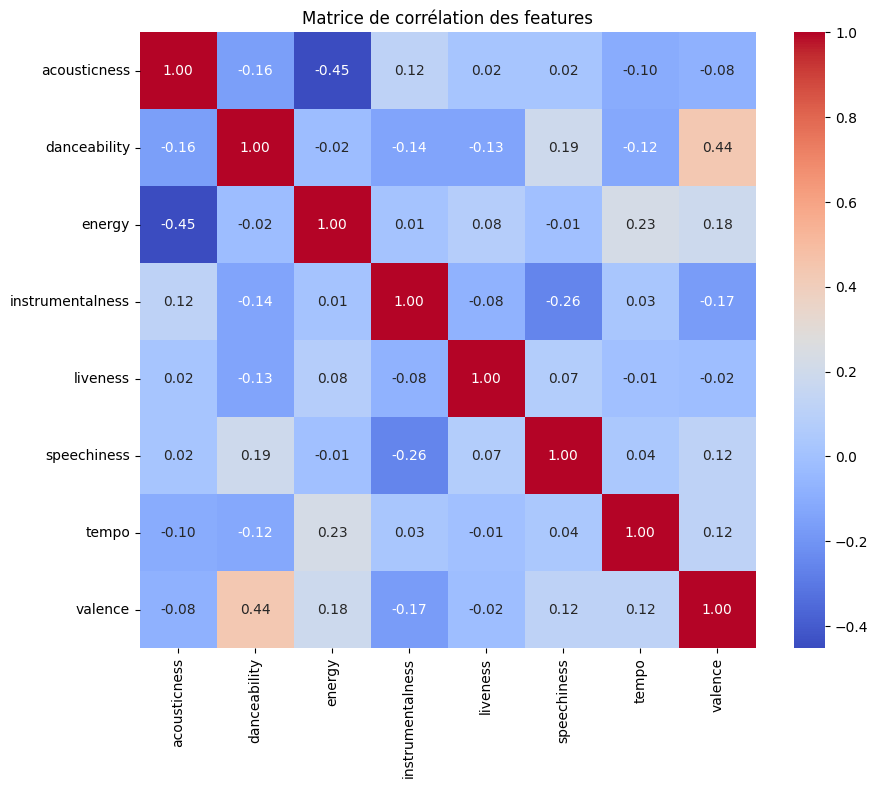

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title("Matrice de corrélation des features")
plt.show()

On remarque qu'acune des features n'est très fortement corrélée avec une autre. On décide donc de toutes les garder étant donné que l'on ne dispose ici que d'un nombre déjà restreint de features.

### III. Entraînement du modèle et prédiction

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

scaler = StandardScaler()
model = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=500) # On oublie pas ici de pondérer pour chaque classe

pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("clf", model)
])

param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 10],
    "clf__penalty": ["l2"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best macro-F1:", grid.best_score_)

Best params: {'clf__C': 10, 'clf__penalty': 'l2'}
Best macro-F1: 0.31092956190743437


In [15]:
y_pred = grid.predict(X_test)

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

                     precision    recall  f1-score   support

          Classical       0.39      0.95      0.55        40
         Electronic       0.61      0.55      0.58       350
               Folk       0.39      0.21      0.28       159
            Hip-Hop       0.50      0.53      0.51       152
       Instrumental       0.02      0.07      0.03        14
      International       0.09      0.43      0.15        23
               Jazz       0.05      0.14      0.07        37
Old-Time / Historic       0.34      0.67      0.45        24
              Other       0.06      0.31      0.10        13
                Pop       0.12      0.24      0.16        59
               Rock       0.85      0.49      0.62       688

           accuracy                           0.47      1559
          macro avg       0.31      0.42      0.32      1559
       weighted avg       0.62      0.47      0.52      1559



Les résultats en prédiction pure ne sont pas très satisfaisants. Cela s'explique tout à fait par la présence de non-linéarités dans ces différentes données musicales agrégées, ainsi que par la forte inégalité de réparttion entre les différentes classes à prédire.

In [ ]:
# Coefficients claculés pour chaque classe
feature_names = X_train.columns

log_reg = grid.best_estimator_.named_steps["clf"]

coef_df = pd.DataFrame(log_reg.coef_, columns=feature_names, index=log_reg.classes_)
coef_df

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
Classical,7.202307,-1.111403,-4.146146,0.331536,0.028492,-0.223577,-0.063362,0.202061
Electronic,-1.977461,0.727270,1.028227,0.575556,-0.036654,0.315360,0.098827,-0.588287
Folk,-0.555372,-0.192695,-0.112308,0.029871,-0.196729,-0.259489,-0.002665,-0.090815
Hip-Hop,-1.750070,0.753373,0.979121,-0.390583,0.029534,0.704109,-0.134977,-0.096810
Instrumental,-1.056943,0.317102,0.742292,-0.042860,0.092593,-0.204884,0.030217,-0.460958
International,-0.097971,-0.058807,0.443014,-0.075755,0.461233,0.194524,0.011523,0.735781
Jazz,-0.921728,-0.672832,0.190162,0.246659,-0.204460,0.298520,-0.174872,-0.171153
Old-Time / Historic,2.863695,0.370358,-1.191349,-0.161525,0.839148,0.076032,0.048096,0.782208
Other,-0.991596,-0.216097,0.006411,-0.214695,-0.721961,0.092177,-0.135999,0.256652
Pop,-1.384905,0.587941,0.742848,-0.324482,-0.142796,-0.639977,0.267350,-0.368293


En revanche les coefficients calculés sont assez informatifs. Le côté vraiment "inteprétable" d'une régression est donc ici pleinement respecté.